In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import (
    Conv2D, 
    Dense, 
    BatchNormalization, 
    Activation, 
    MaxPool2D, 
    GlobalAveragePooling2D, 
    Add, 
    Input, 
    Flatten, 
    LeakyReLU, 
    Concatenate, 
    Dropout,
    MaxPooling2D
)
from tensorflow.keras import Model, Sequential
from tensorflow.keras.constraints import Constraint ,UnitNorm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Orthogonal
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, KLDivergence
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from io import StringIO
import emnist as em
import re
import os

In [3]:
tf.random.set_seed(1234)

## ResNet

In [4]:
# https://arxiv.org/pdf/1512.03385.pdf

In [5]:
def create_resnet(input_shape, class_count):
    n = 9 # 56 layers
    channels = [16, 32, 64]

    inputs = Input(shape=input_shape)
    x = Conv2D(channels[0], kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation(tf.nn.relu)(x)

    for c in channels:
        for i in range(n):
            subsampling = i == 0 and c > 16
            strides = (2, 2) if subsampling else (1, 1)
            y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
            y = BatchNormalization()(y)
            y = Activation(tf.nn.relu)(y)
            y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
            y = BatchNormalization()(y)        
            if subsampling:
                x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
            x = Add()([x, y])
            x = Activation(tf.nn.relu)(x)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(class_count, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

    return Model(inputs=inputs, outputs=outputs)

In [6]:
# PREPARE TRAINING
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9)
import time


class LearningController(Callback):
    def __init__(self, num_epoch=0, learn_minute=0):
        self.num_epoch = num_epoch
        self.learn_second = learn_minute * 60
        if self.learn_second > 0:
            print("Leraning rate is controled by time.")
        elif self.num_epoch > 0:
            print("Leraning rate is controled by epoch.")
        
    def on_train_begin(self, logs=None):
        if self.learn_second > 0:
            self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if self.learn_second > 0:
            current_time = time.time()
            if current_time - self.start_time > self.learn_second / 2:
                self.model.optimizer.lr = lr * 0.1            
            if current_time - self.start_time > self.learn_second * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                
        elif self.num_epoch > 0:
            if epoch > self.num_epoch / 2:
                self.model.optimizer.lr = lr * 0.1            
            if epoch > self.num_epoch * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                    
        print('lr:%.2e' % self.model.optimizer.lr.value())
        

learn_minute = 120

## Dense NN

In [7]:
def create_dense_nn(input_shape, class_count):
    return Sequential(
        [
            Input(shape=input_shape),
            Flatten(),
            Dense(256),
            Dense(class_count),
        ],
    )

## Distiller class

In [8]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [16]:
batch_size = 128
num_epoch = 192

## CIFAR-10

In [17]:
cifar = tfds.load('cifar10', as_supervised = True, batch_size = -1)
cifar_test, cifar_train = cifar['test'], cifar['train']

In [18]:
cifar_train_x = cifar_train[0].numpy() / 255
cifar_train_y = cifar_train[1].numpy()
cifar_test_x = cifar_test[0].numpy() / 255
cifar_test_y = cifar_test[1].numpy()

In [19]:
cifar_train_x, cifar_val_x, cifar_train_y, cifar_val_y = train_test_split(cifar_train_x, cifar_train_y, 
    test_size=0.25, random_state= 8)

## Teacher 

In [20]:
cifar_teacher_model = create_resnet((32, 32, 3), 10)
cifar_teacher_model.type = "cifar_resnet"
cifar_teacher_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 32, 32, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_55 (BatchN  (None, 32, 32, 16)  64          ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_55[0]

In [21]:
cifar_teacher_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cifar_teacher_path = "ResNet-for-CIFAR-10.h5"
cifar_teacher_checkpoint = ModelCheckpoint(filepath = cifar_teacher_path, monitor="val_loss", verbose=1, save_best_only=True)
cifar_teacher_learning_controller = LearningController(num_epoch)
cifar_teacher_callbacks = [cifar_teacher_checkpoint, cifar_teacher_learning_controller]

Leraning rate is controled by epoch.


Epoch 1/191
  6/293 [..............................] - ETA: 23s - loss: 9.5224 - accuracy: 0.0990

293/293 [==============================] - ETA: 0s - loss: 3.4581 - accuracy: 0.1042
Epoch 1: val_loss improved from inf to 3.22777, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 37s 89ms/step - loss: 3.4581 - accuracy: 0.1042 - val_loss: 3.2278 - val_accuracy: 0.0984
Epoch 2/191
293/293 [==============================] - ETA: 0s - loss: 3.1685 - accuracy: 0.0986
Epoch 2: val_loss improved from 3.22777 to 3.11854, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 24s 83ms/step - loss: 3.1685 - accuracy: 0.0986 - val_loss: 3.1185 - val_accuracy: 0.0954
Epoch 3/191
293/293 [==============================] - ETA: 0s - loss: 3.0838 - accuracy: 0.0967
Epoch 3: val_loss improved from 3.11854 to 3.04483, saving model to ResNet-for-CIFAR-10.h5
lr:1.00e-01
293/293 [==============================] - 25s 84ms/step - loss: 3.0838 - accuracy: 0.0967 - val_loss: 3.0448 - val_accuracy: 0.0984
Epoch 4/191
293/2

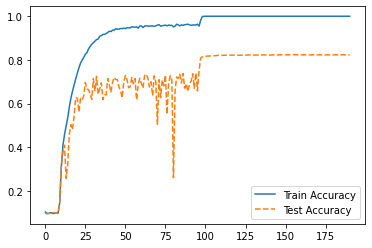

In [22]:
# TRAIN

if os.path.isfile(cifar_teacher_path):
    cifar_teacher_model.load_weights(cifar_teacher_path)
else:
    cifar_history = cifar_teacher_model.fit(cifar_train_x, cifar_train_y,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    validation_data=(cifar_val_x, cifar_val_y), 
                    verbose=1,                    
                    callbacks=cifar_teacher_callbacks)

    plt.plot(cifar_history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(cifar_history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
    plt.legend()
    plt.show()

In [23]:
cifar_teacher_model.evaluate(cifar_test_x, cifar_test_y)

313/313 [==============================] - 3s 10ms/step - loss: 1.2503 - accuracy: 0.8159


[1.250322699546814, 0.8159000277519226]

### Reduced Teacher

In [24]:
cifar_reduced_teacher = create_dense_nn((32, 32, 3), 10)
cifar_reduced_teacher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               786688    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


### CIFAR Teacher - Reduced Teacher Distillation

Epoch 1/20
1172/1172 [==============================] - 47s 35ms/step - sparse_categorical_accuracy: 0.9000 - student_loss: 1.5682 - distillation_loss: 0.1324 - val_sparse_categorical_accuracy: 0.7663 - val_student_loss: 1.7147
Epoch 2/20
1172/1172 [==============================] - 39s 33ms/step - sparse_categorical_accuracy: 0.9071 - student_loss: 1.5595 - distillation_loss: 0.1324 - val_sparse_categorical_accuracy: 0.7110 - val_student_loss: 1.6762
Epoch 3/20
1172/1172 [==============================] - 39s 33ms/step - sparse_categorical_accuracy: 0.9167 - student_loss: 1.5493 - distillation_loss: 0.1326 - val_sparse_categorical_accuracy: 0.7645 - val_student_loss: 1.7162
Epoch 4/20
1172/1172 [==============================] - 40s 34ms/step - sparse_categorical_accuracy: 0.9273 - student_loss: 1.5387 - distillation_loss: 0.1326 - val_sparse_categorical_accuracy: 0.7693 - val_student_loss: 1.6730
Epoch 5/20
1172/1172 [==============================] - 39s 33ms/step - sparse_categoric

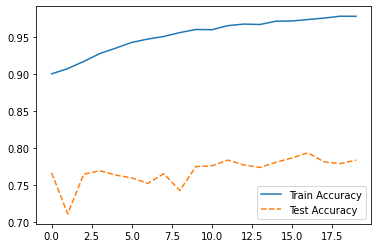

In [25]:
cifar_distiller = Distiller(student=cifar_teacher_model, teacher=cifar_reduced_teacher)
cifar_distiller.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=3,
)

# Distill teacher to student
cifar_reduced_teacher_history = cifar_distiller.fit(cifar_train_x, cifar_train_y, validation_data=(cifar_val_x, cifar_val_y), epochs=20)

# Evaluate student on test dataset
cifar_distiller.evaluate(cifar_test_x, cifar_test_y)

plt.plot(cifar_reduced_teacher_history.history["sparse_categorical_accuracy"], label = 'Train Accuracy')
plt.plot(cifar_reduced_teacher_history.history["val_sparse_categorical_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

## EMINIST

In [32]:
(emnist_train_x, emnist_train_y) = em.extract_training_samples('letters')
emnist_train_x, emnist_train_y = shuffle(emnist_train_x, emnist_train_y)
(emnist_test_x, emnist_test_y) = em.extract_test_samples('letters')
emnist_train_x = emnist_train_x.reshape((emnist_train_x.shape[0], 28, 28, 1))
emnist_test_x = emnist_test_x.reshape((emnist_test_x.shape[0], 28, 28, 1))

In [33]:
emnist_train_x = emnist_train_x.astype('float32')
emnist_test_x = emnist_test_x.astype('float32')
emnist_train_x = emnist_train_x / 255.0
emnist_test_x = emnist_test_x / 255.0

emnist_train_x, emnist_val_x, emnist_train_y, emnist_val_y = train_test_split(emnist_train_x, emnist_train_y, 
    test_size=0.25, random_state= 8)

### Teacher 

In [28]:
emnist_teacher_model = create_resnet((28, 28, 1), 27)
emnist_teacher_model.type = "emnist_resnet"

In [29]:
emnist_teacher_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

emnist_teacher_path = "ResNet-for-EMNIST.h5"
emnist_teacher_checkpoint = ModelCheckpoint(filepath = emnist_teacher_path, monitor="val_loss", verbose=1, save_best_only=True)
emnist_teacher_learning_controller = LearningController(num_epoch)
emnist_teacher_callbacks = [emnist_teacher_checkpoint, emnist_teacher_learning_controller]

Leraning rate is controled by epoch.


Epoch 1/191
731/732 [============================>.] - ETA: 0s - loss: 0.7620 - accuracy: 0.8948
Epoch 1: val_loss improved from 1.51989 to 0.77015, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 52s 71ms/step - loss: 0.7620 - accuracy: 0.8949 - val_loss: 0.7702 - val_accuracy: 0.8890
Epoch 2/191
731/732 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.9127
Epoch 2: val_loss improved from 0.77015 to 0.70164, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 52s 72ms/step - loss: 0.6941 - accuracy: 0.9127 - val_loss: 0.7016 - val_accuracy: 0.9098
Epoch 3/191
731/732 [============================>.] - ETA: 0s - loss: 0.6569 - accuracy: 0.9230
Epoch 3: val_loss improved from 0.70164 to 0.66223, saving model to ResNet-for-EMNIST.h5
lr:1.00e-03
732/732 [==============================] - 51s 70ms/step - loss: 0.6569 - accuracy: 0.9230 - val_loss: 0.6622 - val_accuracy: 0.9213
Epoch 4

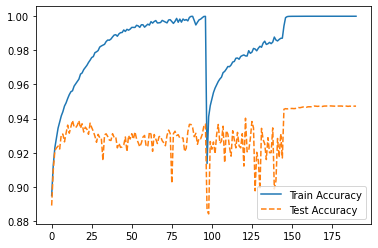

In [32]:
# TRAIN

if os.path.isfile(emnist_teacher_path):
    emnist_teacher_model.load_weights(cifar_teacher_path)
else:
    emnist_history = emnist_teacher_model.fit(emnist_train_x, emnist_train_y, 
                    epochs=num_epoch, 
                    batch_size=batch_size, 
                    validation_data=(emnist_val_x, emnist_val_y), 
                    callbacks=emnist_teacher_callbacks,
          )


    plt.plot(emnist_history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(emnist_history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
    plt.legend()
    plt.show()

In [33]:
emnist_teacher_model.evaluate(emnist_test_x, emnist_test_y)

650/650 [==============================] - 6s 10ms/step - loss: 0.4751 - accuracy: 0.9455


[0.47508567571640015, 0.9454807639122009]

### Reduced Teacher 

In [36]:
emnist_reduced_teacher = create_dense_nn((28, 28, 1), 27)
emnist_reduced_teacher.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               200960    
                                                                 
 dense_8 (Dense)             (None, 27)                6939      
                                                                 
Total params: 207,899
Trainable params: 207,899
Non-trainable params: 0
_________________________________________________________________


### EMNIST Teacher - Reduced Teacher Distillation

Epoch 1/20
2925/2925 [==============================] - 164s 31ms/step - sparse_categorical_accuracy: 0.8982 - student_loss: 2.4639 - distillation_loss: 0.0211 - val_sparse_categorical_accuracy: 0.8772 - val_student_loss: 2.4219
Epoch 2/20
2925/2925 [==============================] - 91s 31ms/step - sparse_categorical_accuracy: 0.9194 - student_loss: 2.4409 - distillation_loss: 0.0211 - val_sparse_categorical_accuracy: 0.8727 - val_student_loss: 2.5147
Epoch 3/20
2925/2925 [==============================] - 93s 32ms/step - sparse_categorical_accuracy: 0.9267 - student_loss: 2.4325 - distillation_loss: 0.0211 - val_sparse_categorical_accuracy: 0.9147 - val_student_loss: 2.4417
Epoch 4/20
2925/2925 [==============================] - 92s 31ms/step - sparse_categorical_accuracy: 0.9316 - student_loss: 2.4273 - distillation_loss: 0.0211 - val_sparse_categorical_accuracy: 0.9279 - val_student_loss: 2.4693
Epoch 5/20
2925/2925 [==============================] - 88s 30ms/step - sparse_categori

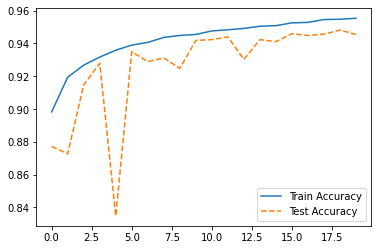

In [37]:
emnist_distiller = Distiller(student=emnist_teacher_model, teacher=emnist_reduced_teacher)
emnist_distiller.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=3,
)

# Distill teacher to student
emnist_reduced_teacher_history = emnist_distiller.fit(emnist_train_x, emnist_train_y, validation_data=(emnist_val_x, emnist_val_y), epochs=20)

# Evaluate student on test dataset
emnist_distiller.evaluate(emnist_test_x, emnist_test_y)

plt.plot(emnist_reduced_teacher_history.history["sparse_categorical_accuracy"], label = 'Train Accuracy')
plt.plot(emnist_reduced_teacher_history.history["val_sparse_categorical_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

# Part 3

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [25]:
parameters = [
    ('gini', 3),
    ('gini', 5),
    ('gini', 10),
    ('entropy', 3),
    ('entropy', 5),
    ('entropy', 10),
]
seed = 1234

## CIFAR-10

In [28]:
cifar_train_x.shape

(37500, 32, 32, 3)

In [29]:
nsamples, nx, ny, dim = cifar_train_x.shape
dt_cifar_train_x = cifar_train_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = cifar_val_x.shape
dt_cifar_val_x = cifar_val_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = cifar_test_x.shape
dt_cifar_test_x = cifar_test_x.reshape((nsamples,nx*ny*dim))

In [30]:
for criterion, max_depth in parameters:
    decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=seed)
    decision_tree.fit(dt_cifar_train_x, cifar_train_y)
    
    cifar_tree_train_predictions = decision_tree.predict(dt_cifar_train_x)
    cifar_tree_val_predictions = decision_tree.predict(dt_cifar_val_x)
    cifar_tree_test_predictions = decision_tree.predict(dt_cifar_test_x)
    
    cifar_tree_train_accuracy = metrics.accuracy_score(cifar_tree_train_predictions, cifar_train_y)
    cifar_tree_val_accuracy = metrics.accuracy_score(cifar_tree_val_predictions, cifar_val_y)
    cifar_tree_test_accuracy = metrics.accuracy_score(cifar_tree_test_predictions, cifar_test_y)
    
    print(f"Tree parameters: critertion - {criterion} max depth - {max_depth}")
    print(f'Training accuracy: {cifar_tree_train_accuracy}%')
    print(f'Validation accuracy: {cifar_tree_val_accuracy}%')
    print(f'Test accuracy: {cifar_tree_test_accuracy}%')
    print()

Tree parameters: critertion - gini max depth - 3
Training accuracy: 0.24013333333333334%
Validation accuracy: 0.23672%
Test accuracy: 0.2398%

Tree parameters: critertion - gini max depth - 5
Training accuracy: 0.27296%
Validation accuracy: 0.26592%
Test accuracy: 0.2642%

Tree parameters: critertion - gini max depth - 10
Training accuracy: 0.4394133333333333%
Validation accuracy: 0.29176%
Test accuracy: 0.2945%

Tree parameters: critertion - entropy max depth - 3
Training accuracy: 0.2392%
Validation accuracy: 0.23368%
Test accuracy: 0.2377%

Tree parameters: critertion - entropy max depth - 5
Training accuracy: 0.2736266666666667%
Validation accuracy: 0.26096%
Test accuracy: 0.2598%

Tree parameters: critertion - entropy max depth - 10
Training accuracy: 0.43933333333333335%
Validation accuracy: 0.2952%
Test accuracy: 0.3034%



## EMNIST

In [34]:
nsamples, nx, ny, dim = emnist_train_x.shape
dt_emnist_train_x = emnist_train_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = emnist_val_x.shape
dt_emnist_val_x = emnist_val_x.reshape((nsamples,nx*ny*dim))

nsamples, nx, ny, dim = emnist_test_x.shape
dt_emnist_test_x = emnist_test_x.reshape((nsamples,nx*ny*dim))

In [35]:
for criterion, max_depth in parameters:
    decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=seed)
    decision_tree.fit(dt_emnist_train_x, emnist_train_y)
    
    emnist_tree_train_predictions = decision_tree.predict(dt_emnist_train_x)
    emnist_tree_val_predictions = decision_tree.predict(dt_emnist_val_x)
    emnist_tree_test_predictions = decision_tree.predict(dt_emnist_test_x)
    
    emnist_tree_train_accuracy = metrics.accuracy_score(emnist_tree_train_predictions, emnist_train_y)
    emnist_tree_val_accuracy = metrics.accuracy_score(emnist_tree_val_predictions, emnist_val_y)
    emnist_tree_test_accuracy = metrics.accuracy_score(emnist_tree_test_predictions, emnist_test_y)
    
    print(f"Tree parameters: critertion - {criterion} max depth - {max_depth}")
    print(f'Training accuracy: {emnist_tree_train_accuracy}%')
    print(f'Validation accuracy: {emnist_tree_val_accuracy}%')
    print(f'Test accuracy: {emnist_tree_test_accuracy}%')
    print()

Tree parameters: critertion - gini max depth - 3
Training accuracy: 0.21027777777777779%
Validation accuracy: 0.20631410256410257%
Test accuracy: 0.20860576923076923%

Tree parameters: critertion - gini max depth - 5
Training accuracy: 0.4167948717948718%
Validation accuracy: 0.412275641025641%
Test accuracy: 0.4084615384615385%

Tree parameters: critertion - gini max depth - 10
Training accuracy: 0.6911752136752137%
Validation accuracy: 0.6471153846153846%
Test accuracy: 0.6442788461538461%

Tree parameters: critertion - entropy max depth - 3
Training accuracy: 0.1983119658119658%
Validation accuracy: 0.1967948717948718%
Test accuracy: 0.19798076923076924%

Tree parameters: critertion - entropy max depth - 5
Training accuracy: 0.4022542735042735%
Validation accuracy: 0.3996794871794872%
Test accuracy: 0.3971153846153846%

Tree parameters: critertion - entropy max depth - 10
Training accuracy: 0.7022008547008547%
Validation accuracy: 0.6594551282051282%
Test accuracy: 0.661346153846153